In [ ]:
# ============================
# 0. Imports & global config
# ============================
import os
import sys
import json
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve, average_precision_score,
    PrecisionRecallDisplay
)



RANDOM_STATE = 42
DATA_PATH = "AmesHousing.csv"   # fișierul original (TSV)
ART_DIR = "L2_artifacts"        # aici salvăm split-urile curate
os.makedirs(ART_DIR, exist_ok=True)

def simple_mode(s: pd.Series):
    m = s.mode(dropna=True)
    return m.iloc[0] if len(m) else np.nan

# Clips negative numeric values (area/count columns) to zero.
def enforce_nonnegative(df: pd.DataFrame) -> pd.DataFrame:
    """Clip logical non-negative numerics at 0 (defensive net)."""
    nonneg = [
        'Lot Area','Lot Frontage','Gr Liv Area',
        'BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF',
        'Garage Area','Garage Cars','1st Flr SF','2nd Flr SF','Low Qual Fin SF',
        'Wood Deck SF','Open Porch SF','Enclosed Porch','3Ssn Porch','Screen Porch',
        'Pool Area','SalePrice'
    ]
    for c in nonneg:
        if c in df.columns:
            df[c] = df[c].clip(lower=0)
    return df

def normalize_categoricals(df: pd.DataFrame) -> pd.DataFrame:
    """Trim/standardize string categories (avoids hidden ‘NaN ’, ‘ y ’, etc.)."""
    obj_cols = df.select_dtypes(include='object').columns
    for c in obj_cols:
        df[c] = df[c].astype(str).str.strip()
        df.loc[df[c].isin(['', 'nan', 'None', 'NaT']), c] = np.nan
    # Central Air should be Y/N
    if 'Central Air' in df.columns:
        df['Central Air'] = df['Central Air'].replace({'Yes': 'Y', 'No': 'N', 'y': 'Y', 'n': 'N'})
    return df

def apply_absence_labels(df: pd.DataFrame) -> pd.DataFrame:
    na_none_map = {
        'Alley': 'NoAlley',
        'Bsmt Qual': 'NoBasement','Bsmt Cond': 'NoBasement','Bsmt Exposure': 'NoBasement',
        'BsmtFin Type 1': 'NoBasement','BsmtFin Type 2': 'NoBasement',
        'Fireplace Qu': 'NoFireplace',
        'Garage Type': 'NoGarage','Garage Finish': 'NoGarage','Garage Qual': 'NoGarage','Garage Cond': 'NoGarage',
        'Pool QC': 'NoPool','Fence': 'NoFence','Misc Feature': 'NoFeature'
    }
    for col, val in na_none_map.items():
        if col in df.columns:
            df[col] = df[col].replace('NA', val).fillna(val)
    return df

def fix_basement_consistency(df: pd.DataFrame) -> pd.DataFrame:
    parts = ['BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF']; total = 'Total Bsmt SF'
    has_bsmt_area = (df[parts].fillna(0).sum(axis=1) > 0)
    bad_expo = has_bsmt_area & (df['Bsmt Exposure'] == 'NoBasement')
    df['Fix_BsmtExposure'] = 0
    df.loc[bad_expo, 'Bsmt Exposure'] = 'No'
    df.loc[bad_expo, 'Fix_BsmtExposure'] = 1

    sum_parts = df[parts].fillna(0).sum(axis=1)
    all_parts_na = df[parts].isna().all(axis=1)
    total_na = df[total].isna()

    mask_true_mismatch = (~all_parts_na) & (~total_na) & (df[total] != sum_parts)
    mask_total_missing = (~all_parts_na) & total_na
    df.loc[mask_true_mismatch, total] = sum_parts[mask_true_mismatch]
    df.loc[mask_total_missing, total] = sum_parts[mask_total_missing]

    mask_parts_missing = all_parts_na & (~total_na)
    for c in parts:
        df.loc[mask_parts_missing, c] = df.loc[mask_parts_missing, c].fillna(0)

    mask_all_missing = all_parts_na & total_na & (df['Bsmt Qual'] == 'NoBasement')
    for c in parts + [total]:
        df.loc[mask_all_missing, c] = 0
    return df

def consolidate_garage_absence(df: pd.DataFrame) -> pd.DataFrame:
    """If no garage (type/area/cars imply absence), zero numerics + set labels to NoGarage."""
    g_zero = (df.get('Garage Cars', 0).fillna(0) == 0) & (df.get('Garage Area', 0).fillna(0) == 0)
    if 'Garage Type' in df.columns:
        g_abs = (df['Garage Type'] == 'NoGarage') | g_zero
        for c in ['Garage Finish','Garage Qual','Garage Cond','Garage Type']:
            if c in df.columns:
                df.loc[g_abs, c] = 'NoGarage'
        for c in ['Garage Yr Blt','Garage Area','Garage Cars']:
            if c in df.columns:
                df.loc[g_abs, c] = 0
    return df

def apply_time_filters(df: pd.DataFrame) -> pd.DataFrame:
    df = df[(df['Yr Sold'] >= df['Year Built']) & (df['Yr Sold'] >= df['Year Remod/Add'])].copy()
    df = df[df['Year Remod/Add'] >= df['Year Built']].copy()
    mask_gyear_ok = (~df['Garage Yr Blt'].notna()) | (
        (df['Garage Yr Blt'] >= 1880) & (df['Garage Yr Blt'] <= (df['Yr Sold'] + 1))
    )
    return df[mask_gyear_ok].copy()

def add_binary_flags(df: pd.DataFrame) -> pd.DataFrame:
    df['HasPool']   = (df['Pool Area'] > 0).astype(int)
    df['HasFire']   = (df['Fireplaces'] > 0).astype(int)
    df['HasAC']     = (df['Central Air'] == 'Y').astype(int)
    df['HasFence']  = (df['Fence'] != 'NoFence').astype(int)
    df['HasGarage'] = (df['Garage Cars'].fillna(0) > 0).astype(int)
    df['AmenitiesCount'] = df[['HasPool','HasFire','HasAC','HasFence','HasGarage']].sum(axis=1)
    return df

def drop_low_signal_columns(df: pd.DataFrame) -> pd.DataFrame:
    to_drop = ['Utilities','Street','Condition 2','Roof Matl','Heating','Pool QC','Misc Feature','Garage Cond']
    keep = [c for c in to_drop if c in df.columns]
    return df.drop(columns=keep).copy()

def ordinal_encode_inplace(df: pd.DataFrame) -> pd.DataFrame:
    ord_orders = {
        'Exter Qual':['Po','Fa','TA','Gd','Ex'],'Exter Cond':['Po','Fa','TA','Gd','Ex'],
        'Bsmt Qual':['NoBasement','Po','Fa','TA','Gd','Ex'],'Bsmt Cond':['NoBasement','Po','Fa','TA','Gd','Ex'],
        'Bsmt Exposure':['NoBasement','No','Mn','Av','Gd'],
        'BsmtFin Type 1':['NoBasement','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],
        'BsmtFin Type 2':['NoBasement','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],
        'Heating QC':['Po','Fa','TA','Gd','Ex'],'Electrical':['FuseP','FuseF','Mix','FuseA','SBrkr'],
        'Kitchen Qual':['Po','Fa','TA','Gd','Ex'],'Fireplace Qu':['NoFireplace','Po','Fa','TA','Gd','Ex'],
        'Garage Finish':['NoGarage','Unf','RFn','Fin'],'Garage Qual':['NoGarage','Po','Fa','TA','Gd','Ex'],
        'Paved Drive':['N','P','Y'],'Lot Shape':['IR3','IR2','IR1','Reg'],'Land Slope':['Sev','Mod','Gtl'],
    }
    for col, order in ord_orders.items():
        if col in df.columns:
            cat = pd.Categorical(df[col], categories=order, ordered=True)
            s = pd.Series(cat.codes, index=df.index).astype('float64')
            s[s == -1] = np.nan
            df[col] = s
    return df

def bucket_rare(df: pd.DataFrame, cols: list, min_count: int = 5) -> pd.DataFrame:
    for c in cols:
        if c in df.columns:
            s = df[c].astype(str)  # TODO check--> edge case
            vc = df[c].value_counts(dropna=False)
            rare = set(vc[vc < min_count].index)
            df[c] = df[c].where(~df[c].isin(rare), "__Other__")
    return df

In [2]:
def compute_train_stats(df_tr: pd.DataFrame):
    stats = {}
    if 'Lot Frontage' in df_tr.columns and 'Neighborhood' in df_tr.columns:
        stats['lf_med_nb']   = df_tr.groupby('Neighborhood')['Lot Frontage'].median()
        stats['lf_med_glob'] = df_tr['Lot Frontage'].median()
    else:
        stats['lf_med_nb'] = pd.Series(dtype='float64'); stats['lf_med_glob'] = np.nan

    label_cols_all = ['Garage Finish','Garage Qual','Garage Cond']
    label_cols = [c for c in label_cols_all if c in df_tr.columns]
    g_has_tr = (
        (df_tr.get('Garage Type', 'NoGarage') != 'NoGarage') |
        (df_tr.get('Garage Area', pd.Series(0, index=df_tr.index)).fillna(0) > 0) |
        (df_tr.get('Garage Cars', pd.Series(0, index=df_tr.index)).fillna(0) > 0)
    )
    if 'Garage Type' in df_tr.columns and any(label_cols):
        try:
            stats['g_modes_by_type'] = df_tr[g_has_tr].groupby('Garage Type')[label_cols].agg(simple_mode)
        except Exception:
            stats['g_modes_by_type'] = pd.DataFrame()
    else:
        stats['g_modes_by_type'] = pd.DataFrame()

    stats['g_med_area_by_type'] = (df_tr[g_has_tr].groupby('Garage Type')['Garage Area'].median()
                                   if {'Garage Type','Garage Area'} <= set(df_tr.columns) else pd.Series(dtype='float64'))
    stats['g_med_cars_by_type'] = (df_tr[g_has_tr].groupby('Garage Type')['Garage Cars'].median()
                                   if {'Garage Type','Garage Cars'} <= set(df_tr.columns) else pd.Series(dtype='float64'))

    if {'Mas Vnr Area','Mas Vnr Type'} <= set(df_tr.columns):
        ref = df_tr[(df_tr['Mas Vnr Area'].fillna(0) > 0) & df_tr['Mas Vnr Type'].notna() & (df_tr['Mas Vnr Type'] != 'None')]
        stats['mvt_nb_mode'] = (ref.groupby('Neighborhood')['Mas Vnr Type'].agg(simple_mode)
                                if 'Neighborhood' in df_tr.columns else pd.Series(dtype='object'))
        gmode = df_tr['Mas Vnr Type'].dropna().mode()
        stats['mvt_global_mode'] = gmode.iloc[0] if len(gmode) else 'BrkFace'
    else:
        stats['mvt_nb_mode'] = pd.Series(dtype='object'); stats['mvt_global_mode'] = 'BrkFace'

    num_cols = [c for c in df_tr.select_dtypes(include=[np.number]).columns if c != 'SalePrice']
    stats['num_medians'] = df_tr[num_cols].median(numeric_only=True)
    return stats

def apply_train_stats(df_block: pd.DataFrame, stats: dict) -> pd.DataFrame:
    if {'Lot Frontage','Neighborhood'} <= set(df_block.columns) and not pd.isna(stats.get('lf_med_glob', np.nan)):
        df_block['Lot Frontage'] = df_block['Lot Frontage'].fillna(df_block['Neighborhood'].map(stats['lf_med_nb'])).fillna(stats['lf_med_glob'])

    g_has = (
        (df_block.get('Garage Type', 'NoGarage') != 'NoGarage') |
        (df_block.get('Garage Area', pd.Series(0, index=df_block.index)).fillna(0) > 0) |
        (df_block.get('Garage Cars', pd.Series(0, index=df_block.index)).fillna(0) > 0)
    )
    if isinstance(stats.get('g_modes_by_type'), pd.DataFrame) and not stats['g_modes_by_type'].empty and 'Garage Type' in df_block.columns:
        need_fix = g_has & (
            (df_block.get('Garage Finish', pd.Series(np.nan, index=df_block.index)).isna()) |
            (df_block.get('Garage Qual',   pd.Series(np.nan, index=df_block.index)).isna()) |
            (df_block.get('Garage Cond',   pd.Series(np.nan, index=df_block.index)).isna()) |
            (df_block.get('Garage Finish', pd.Series('NoGarage', index=df_block.index)) == 'NoGarage') |
            (df_block.get('Garage Qual',   pd.Series('NoGarage', index=df_block.index)) == 'NoGarage') |
            (df_block.get('Garage Cond',   pd.Series('NoGarage', index=df_block.index)) == 'NoGarage')
        )
        for c in ['Garage Finish','Garage Qual','Garage Cond']:
            if c in df_block.columns and c in stats['g_modes_by_type'].columns:
                fill_vals = df_block.loc[need_fix, 'Garage Type'].map(stats['g_modes_by_type'][c])
                df_block.loc[need_fix, c] = df_block.loc[need_fix, c].fillna(fill_vals)

    if {'Garage Area','Garage Type'} <= set(df_block.columns) and not stats.get('g_med_area_by_type', pd.Series()).empty:
        m_area_na = g_has & df_block['Garage Area'].isna()
        df_block.loc[m_area_na, 'Garage Area'] = df_block.loc[m_area_na, 'Garage Type'].map(stats['g_med_area_by_type'])
    if {'Garage Cars','Garage Type'} <= set(df_block.columns) and not stats.get('g_med_cars_by_type', pd.Series()).empty:
        m_cars_na = g_has & df_block['Garage Cars'].isna()
        df_block.loc[m_cars_na, 'Garage Cars'] = df_block.loc[m_cars_na, 'Garage Type'].map(stats['g_med_cars_by_type'])

    if {'Mas Vnr Area','Mas Vnr Type'} <= set(df_block.columns):
        area = df_block['Mas Vnr Area']; typ = df_block['Mas Vnr Type']
        m_area0 = area.fillna(0) == 0; m_area_pos = area.fillna(0) > 0
        m_type_none = typ == 'None'; m_type_na = typ.isna()
        df_block.loc[m_type_na & m_area0, 'Mas Vnr Type'] = 'None'
        df_block.loc[(~m_type_none & ~m_type_na) & m_area0, 'Mas Vnr Type'] = 'None'
        mask_pos_missing = m_area_pos & (m_type_none | m_type_na)
        nb_mode = stats.get('mvt_nb_mode', pd.Series(dtype='object')); global_mode = stats.get('mvt_global_mode', 'BrkFace')
        if not nb_mode.empty and 'Neighborhood' in df_block.columns:
            nb_fill = df_block.loc[mask_pos_missing, 'Neighborhood'].map(nb_mode).fillna(global_mode)
        else:
            nb_fill = pd.Series(global_mode, index=df_block.index).loc[mask_pos_missing]
        df_block.loc[mask_pos_missing, 'Mas Vnr Type'] = nb_fill
    return df_block

def fill_not_present_numerics(df_block: pd.DataFrame) -> pd.DataFrame:
    exist_num = ['Garage Yr Blt','Garage Area','Garage Cars',
                 'BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF',
                 'Bsmt Full Bath','Bsmt Half Bath','Pool Area','Mas Vnr Area']
    for c in exist_num:
        if c in df_block.columns:
            df_block[f'{c}_was_missing'] = df_block[c].isna().astype(int)
            df_block[c] = df_block[c].fillna(0)
    return df_block

def fill_remaining_numerics_with_train_median(df_block: pd.DataFrame, num_medians: pd.Series) -> pd.DataFrame:
    for c in df_block.select_dtypes(include=[np.number]).columns:
        if df_block[c].isna().any():
            df_block[c] = df_block[c].fillna(num_medians.get(c, df_block[c].median()))
    return df_block

In [3]:
def generate_sanity_report(df_raw, df_train_clean, df_test_clean, meta, make_plots=True):
    df_clean_all = pd.concat([df_train_clean, df_test_clean], ignore_index=True)
    n_raw = meta.get('n_raw', len(df_raw)); n_after_time = meta.get('n_after_time', len(df_clean_all))
    dropped_time = n_raw - n_after_time; pct_dropped = (dropped_time / n_raw) * 100 if n_raw else 0
    print("=== Sanity report ===")
    print(f"- Rows initiale: {n_raw}")
    print(f"- După filtre temporale: {n_after_time}  (drop: {dropped_time} | {pct_dropped:.2f}%)")
    n_fix_bsmt = meta.get('n_fix_bsmt_exposure', int(df_clean_all.get('Fix_BsmtExposure', pd.Series(0)).sum()))
    print(f"- Corecții Bsmt Exposure (NoBasement -> No când există arii): {n_fix_bsmt}")

    parts = ['BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF']; total = 'Total Bsmt SF'
    if all(c in df_clean_all.columns for c in parts+[total]):
        mismatch = (df_clean_all[total] != df_clean_all[parts].fillna(0).sum(axis=1)).sum()
        print(f"- Identități subsol (Total == sum(parts)) → mismatches: {mismatch}")
    else:
        print("- Identități subsol: coloane lipsă, skip.")

    na_raw = df_raw.isna().sum().sort_values(ascending=False)
    na_clean = df_clean_all.isna().sum().sort_values(ascending=False)
    print("\nTop 10 coloane cu NaN (înainte):"); print(na_raw.head(10))
    print("\nTop 10 coloane cu NaN (după curățare):"); print(na_clean.head(10))
    print(f"\nShapes: train={df_train_clean.shape}, test={df_test_clean.shape}")
    if 'SalePrice' in df_raw.columns:
        sp_raw = df_raw['SalePrice'].dropna(); sp_clean = df_clean_all['SalePrice'].dropna()
        print(f"SalePrice (raw):   n={sp_raw.size}, min={sp_raw.min():,.0f}, median={sp_raw.median():,.0f}, max={sp_raw.max():,.0f}")
        print(f"SalePrice (clean): n={sp_clean.size}, min={sp_clean.min():,.0f}, median={sp_clean.median():,.0f}, max={sp_clean.max():,.0f}")

    if make_plots:
        try: plot_sanity(df_raw, df_clean_all)
        except Exception as e: print(f"(plot warning) {e}")

def plot_sanity(df_raw, df_clean):
    if 'SalePrice' in df_raw.columns and 'SalePrice' in df_clean.columns:
        plt.figure(figsize=(7,4))
        plt.hist(df_raw['SalePrice'].dropna(), bins=50, alpha=0.35, label='raw')
        plt.hist(df_clean['SalePrice'].dropna(), bins=50, alpha=0.6, label='clean')
        plt.title("SalePrice: raw vs clean (hist)"); plt.xlabel("SalePrice"); plt.ylabel("count"); plt.legend(); plt.tight_layout(); plt.show()
    if all(c in df_clean.columns for c in ['Gr Liv Area','SalePrice']):
        plt.figure(figsize=(6,4))
        plt.scatter(df_clean['Gr Liv Area'], df_clean['SalePrice'], s=8, alpha=0.5)
        plt.title("SalePrice vs Gr Liv Area (clean)"); plt.xlabel("Gr Liv Area"); plt.ylabel("SalePrice"); plt.tight_layout(); plt.show()

def validate_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """Return a small table of issues (row_idx, column, rule, value) without mutating df."""
    issues = []
    def report(mask, col, rule):
        idx = df.index[mask]
        for i in idx:
            issues.append((int(i), col, rule, df.at[i, col] if col in df.columns else None))

    if {'Mo Sold','Yr Sold'} <= set(df.columns):
        report(~df['Mo Sold'].between(1,12), 'Mo Sold', 'month_out_of_range')
        report(~df['Yr Sold'].between(1800, 2100), 'Yr Sold', 'year_out_of_range')

    if {'Overall Qual','Overall Cond'} <= set(df.columns):
        report(~df['Overall Qual'].between(1,10), 'Overall Qual', 'qual_out_of_range')
        report(~df['Overall Cond'].between(1,10), 'Overall Cond', 'cond_out_of_range')

    if {'Year Built','Year Remod/Add'} <= set(df.columns):
        report(df['Year Remod/Add'] < df['Year Built'], 'Year Remod/Add', 'remod_before_built')

    if {'Garage Yr Blt','Yr Sold'} <= set(df.columns):
        gy = df['Garage Yr Blt']; ys = df['Yr Sold']
        report(gy.notna() & (gy < 1880), 'Garage Yr Blt', 'garage_too_old')
        report(gy.notna() & (gy > ys + 1), 'Garage Yr Blt', 'garage_after_sale+1')

    pos_when_present = ['Gr Liv Area','1st Flr SF','SalePrice']
    for c in pos_when_present:
        if c in df.columns:
            report(df[c] < 0, c, 'negative_value')

    return pd.DataFrame(issues, columns=['row_idx','column','rule','value'])

In [7]:
def clean_ames(csv_path: str,
               test_size: float = 0.2,
               random_state: int = 42,
               return_meta: bool = False,
               use_rare_bucket: bool = False,
               winsorize: bool = False,
               drop_exact_duplicates: bool = True,
               drop_audit_flags: bool = True):
    """
    Deterministic, leak-free cleaning. Outlier trimming is OFF by default (see train_band_filter).
    """
    df_raw = pd.read_csv(csv_path, sep="\t")
    meta = {'n_raw': len(df_raw), 'na_raw_top': df_raw.isna().sum().sort_values(ascending=False).head(10)}

    # ---- Safe pre-split steps
    df = df_raw.copy()
    df = normalize_categoricals(df)
    df = apply_absence_labels(df)
    df = fix_basement_consistency(df)
    df = consolidate_garage_absence(df)
    df = enforce_nonnegative(df)

    if drop_exact_duplicates:
        before = len(df); df = df.drop_duplicates().copy(); meta['n_dropped_dupes'] = before - len(df)

    n_before_time = len(df)
    df = apply_time_filters(df)
    meta['n_after_time'] = len(df); meta['n_dropped_time'] = n_before_time - meta['n_after_time']

    df = add_binary_flags(df)
    df = drop_low_signal_columns(df)

    if use_rare_bucket:
        nominal_candidates = ['MS SubClass','MS Zoning','Neighborhood','Condition 1','Bldg Type','House Style',
                              'Roof Style','Exterior 1st','Exterior 2nd','Mas Vnr Type','Foundation','Lot Config',
                              'Land Contour','Garage Type','Sale Type','Sale Condition']
        nominal_cols = [c for c in nominal_candidates if c in df.columns]
        df = bucket_rare(df, nominal_cols, min_count=5)

    df = ordinal_encode_inplace(df)



    # Drop IDs
    df = df.drop(columns=['Order','PID'], errors='ignore')

# ---- Train-only stats (entire df is "train")
    stats = compute_train_stats(df)
    df = apply_train_stats(df, stats)

# Not-present numerics → 0 (+indicator)
    df = fill_not_present_numerics(df)

# (optional) winsorization — numeric features only (no target)
    if winsorize:
        num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != 'SalePrice']
        q_lo = df[num_cols].quantile(0.01)
        q_hi = df[num_cols].quantile(0.99)
        for c in num_cols:
            df[c] = df[c].clip(lower=q_lo.get(c, df[c].min()), upper=q_hi.get(c, df[c].max()))

    # Remaining numerics → train medians
    df = fill_remaining_numerics_with_train_median(df, stats['num_medians'])

    # Reset index
    df = df.reset_index(drop=True)

    # ---- Meta checks
    meta['n_fix_bsmt_exposure'] = int(df.get('Fix_BsmtExposure', pd.Series(0)).sum())

    parts = ['BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF']
    total = 'Total Bsmt SF'
    meta['post_clean_bsmt_mismatch'] = (
        int((df[total] != df[parts].fillna(0).sum(axis=1)).sum())
        if all(c in df.columns for c in parts + [total]) else None
    )

    meta['na_clean_top'] = df.isna().sum().sort_values(ascending=False).head(10)

    # Validation report (non-fatal)
    meta['validation_issues'] = validate_dataset(df).head(15)

    # --- Drop audit flags after meta/report, if requested
    if drop_audit_flags:
        audit_cols = ['Fix_BsmtExposure', 'Fix_Garage']
        df = df.drop(columns=[c for c in audit_cols if c in df.columns], errors='ignore')


    return df


In [ ]:
csv_path = "AmesHousing.csv"
df = clean_ames(csv_path)
df.drop("SalePrice", axis=1)

Benutze das gereinigte Ames Housing Dataset, mit passendem encoding für die kategorischen Features und skaliere den Datensatz mit min-max scaling. Siehe auch link, link         ce cartier frumos uau
AICI INCEPE!!!!!!!!11
AICI INCEPE!!!!!!!!11
AICI INCEPE!!!!!!!!11
AICI INCEPE!!!!!!!!11
v
AICI INCEPE!!!!!!!!11
 
AICI INCEPE!!!!!!!!11
AICI INCEPE!!!!!!!!11
AICI INCEPE!!!!!!!!11
AICI INCEPE!!!!!!!!11
AICI INCEPE!!!!!!!!11
AICI INCEPE!!!!!!!!11
AICI INCEPE!!!!!!!!11
AICI INCEPE!!!!!!!!11

AICI INCEPE!!!!!!!!11
AICI INCEPE!!!!!!!!11

  
AICI INCEPE!!!!!!!!11
AICI INCEPE!!!!!!!!11
AICI INCEPE!!!!!!!!11

In [ ]:
# PCA transforms your  features into new features called principal components (PCs).
#   explained_variance_ratio  :   i = how much of the dataset’s total information PC_i contains
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#Benutze PCA, um den Datensatz auf 98% der Varianz zu reduzieren. 
#Wie viel von der Varianz des Datensatzes erklärt jede Principal component (siehe hier - explained_variance_ratio)?
#Mit wie vielen Features bleibt man?


X = df.select_dtypes(include=[np.number]) 

pca = PCA(n_components=0.98, random_state=42)  # retain 98% of variance
X_pca = pca.fit_transform(X)
explained_ratios = pca.explained_variance_ratio_
n_features = X_pca.shape[1]

print("Explained variance ratio per component:", explained_ratios)
print("Number of features after PCA:", n_features)
print("Cumulative variance explained:", explained_ratios.cumsum()[-1])
print (" ")

#am facut scaling aici ca habar n am care varianta ii mai buna, oricum varianta e peste 0.98 in ambele cazuri so more meaningful PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.98, random_state=42)  # retain 98% of variance
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio per component:", explained_ratios)
print("Number of features after PCA:", n_features)
print("Cumulative variance explained:", explained_ratios.cumsum()[-1])

#explained_ratios → a list where each value is variance explained by one PC.
#n_features → the number of principal components you keep to retain 98% of the variance.
#explained_ratios.cumsum() → cumulative variance captured by the first N components. The last value should be ≥0.98.

Explained variance ratio per component: [0.99046874]
Number of features after PCA: 1
Cumulative variance explained: 0.9904687379813287
 
Explained variance ratio per component: [0.99046874]
Number of features after PCA: 1
Cumulative variance explained: 0.9904687379813287


PCs needed for 95% variance: 41
PCs needed for 90% variance: 35
PCs needed for 80% variance: 26


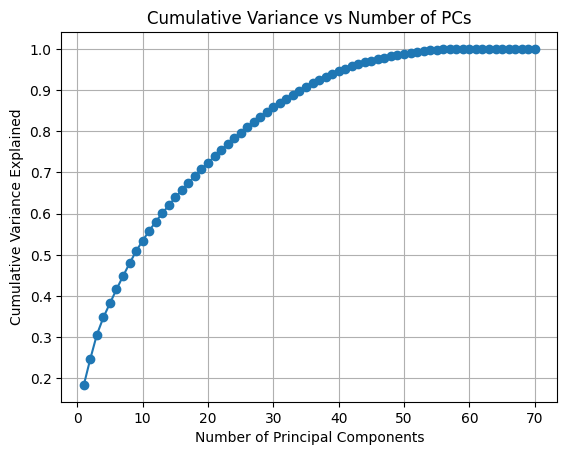

In [ ]:
#Wie viele Principal Components sind nötig wenn man 95%, 90%, 80% der Varianz behalten will?
#Zeichne die kumulative Varianz als Funktion der Anzahl von Principal Components.

pca_full = PCA(n_components=None, random_state=42)
X_pca_full = pca_full.fit_transform(X_scaled)
cumulative_variance = pca_full.explained_variance_ratio_.cumsum()

thresholds = [0.95, 0.90, 0.80]
for t in thresholds:
    n_pc = (cumulative_variance < t).sum() + 1
    print(f"PCs needed for {int(t*100)}% variance: {n_pc}")

# Plot cumulative variance
import matplotlib.pyplot as plt
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.title("Cumulative Variance vs Number of PCs")
plt.grid(True)
plt.show()

#The first few PCs capture most of the variance because they align with directions of highest variability in the data.
#Later PCs explain smaller and smaller portions of variance. These components often correspond to subtle differences or noise in the dataset.

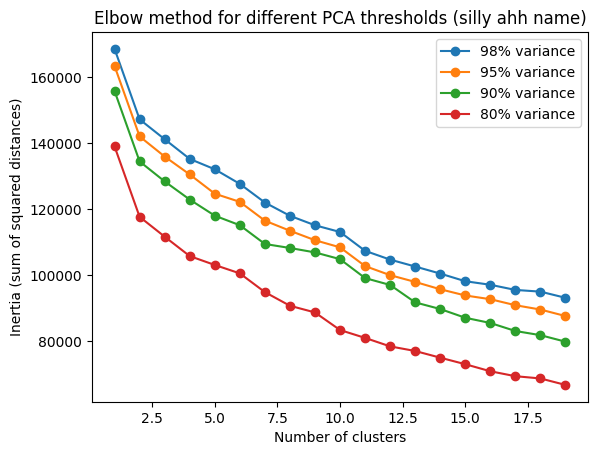

In [38]:
#Mit dem auf mehrere möglichen Schwellen der Varianz reduzierten Datensatz trainiere je ein k-Means Clustering Modell

variance_thresholds = [0.98, 0.95, 0.90, 0.80]
X_pca_dict = {}
pca_models = {} 

for t in variance_thresholds:
    pca = PCA(n_components=t, random_state=42)
    X_pca_dict[t] = pca.fit_transform(X_scaled)
    pca_models[t] = pca 

from sklearn.cluster import KMeans

kmeans_models = {}

for t, X_pca in X_pca_dict.items():
    kmeans = KMeans(n_clusters=20, random_state=42)  # start with 3 clusters (you can change)
    kmeans.fit(X_pca)
    kmeans_models[t] = kmeans

#Benutze die Ellenbogenmethode um die optimale Anzahl der Cluster zu finden.   
for t, X_pca in X_pca_dict.items():
    inertia = []
    for k in range(1, 20):
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(X_pca)
        inertia.append(km.inertia_)
    plt.plot(range(1, 20), inertia, marker='o', label=f'{int(t*100)}% variance')


plt.xlabel('Number of clusters')
plt.ylabel('Inertia (sum of squared distances)')
plt.title('Elbow method for different PCA thresholds (silly ahh name)')
plt.legend()
plt.show()
#Zeichne das Plot.


lwk nu stiu cat de mare sa fac ala ca am facut cu 11 cu 15 cu 20 si nu pare sa scada 

How the elbow method works:

Run k-means for different values of k (e.g., 1 to 10).

Plot inertia vs k.

Inertia decreases as k increases (more clusters → smaller distances to centroids).

Look for the “elbow” point:

The point after which increasing k doesn’t reduce inertia much.

This is where the curve starts to flatten.

The elbow point represents the optimal number of clusters, because adding more clusters after that gives diminishing returns.


--- PCA 98% variance ---
Number of clusters: 20
Average silhouette score: 0.082


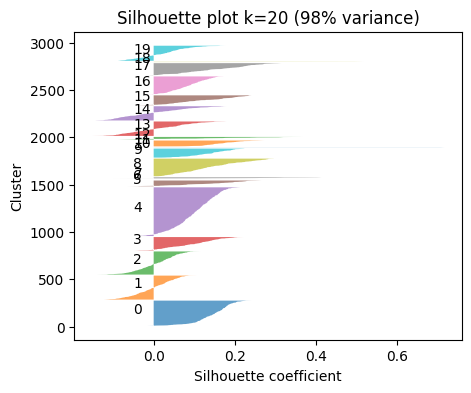

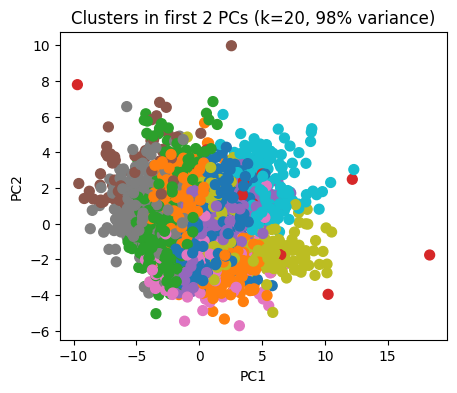


--- PCA 95% variance ---
Number of clusters: 20
Average silhouette score: 0.084


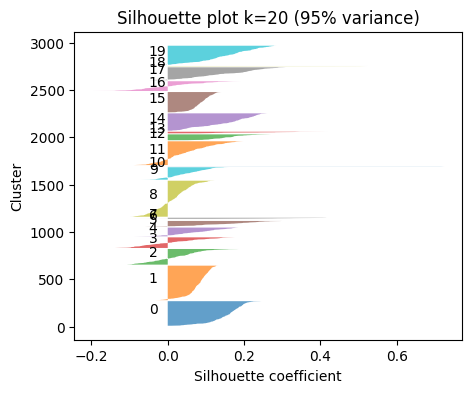

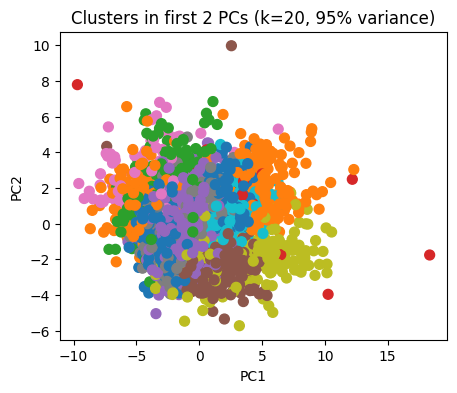


--- PCA 90% variance ---
Number of clusters: 20
Average silhouette score: 0.095


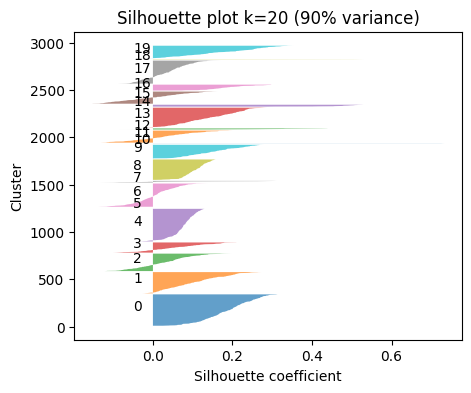

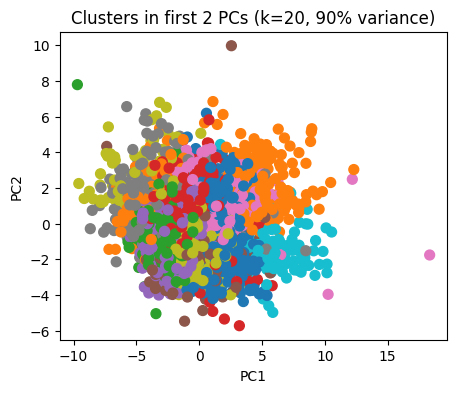


--- PCA 80% variance ---
Number of clusters: 20
Average silhouette score: 0.123


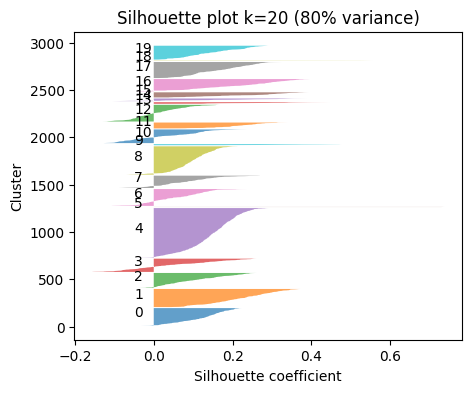

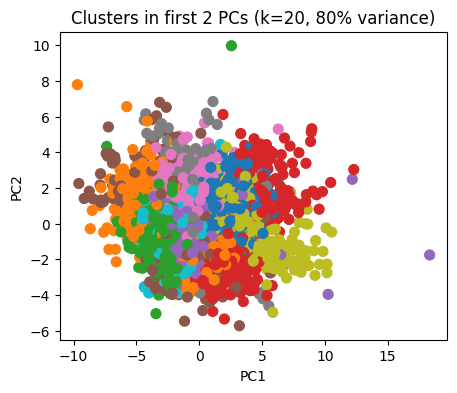

In [ ]:
#Zeichne Silhouettenplots für mehrere Anzahlen von Clusters. 

#Silhouette measures how well points fit in their cluster: +1 → perfect match to its cluster 0 → on the border -1 → probably in the wrong cluster

from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np


# Loop over all trained models in your dictionary
for t, kmeans in kmeans_models.items():
    X_pca = X_pca_dict[t]       
    labels = kmeans.labels_     
    k_opt = kmeans.n_clusters   
    
    print(f"\n--- PCA {int(t*100)}% variance ---")
    print(f"Number of clusters: {k_opt}")
    
    # Silhouette
    silhouette_avg = silhouette_score(X_pca, labels)
    print(f"Average silhouette score: {silhouette_avg:.3f}")
    
    sample_silhouette_values = silhouette_samples(X_pca, labels)
    
    plt.figure(figsize=(5,4))
    y_lower = 10
    for i in range(k_opt):
        ith_cluster_silhouette = sample_silhouette_values[labels == i]
        ith_cluster_silhouette.sort()
        size_cluster_i = ith_cluster_silhouette.shape[0]
        y_upper = y_lower + size_cluster_i
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5*size_cluster_i, str(i))
        y_lower = y_upper + 10
    plt.xlabel("Silhouette coefficient")
    plt.ylabel("Cluster")
    plt.title(f"Silhouette plot k={k_opt} ({int(t*100)}% variance)")
    plt.show()
    
    # Scatter plot (first 2 PCs)
    plt.figure(figsize=(5,4))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='tab10', s=50)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"Clusters in first 2 PCs (k={k_opt}, {int(t*100)}% variance)")
    plt.show()



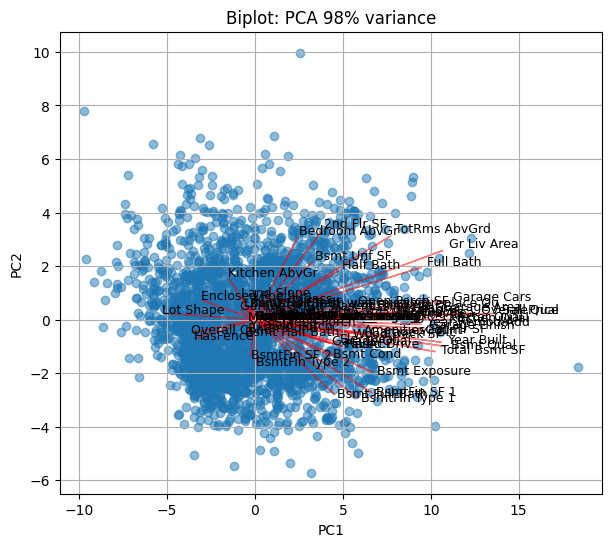

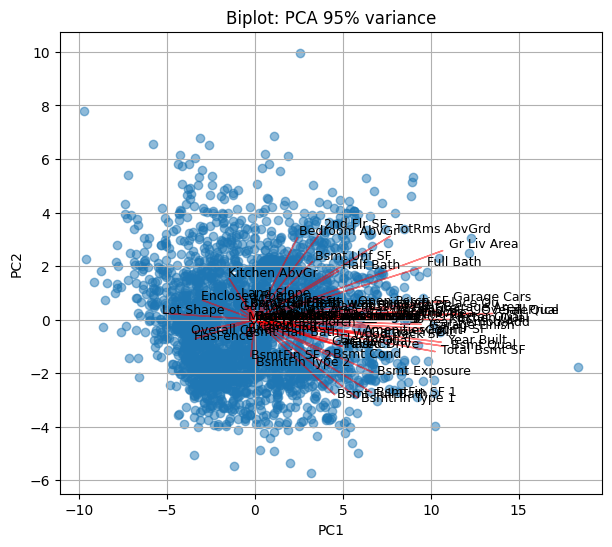

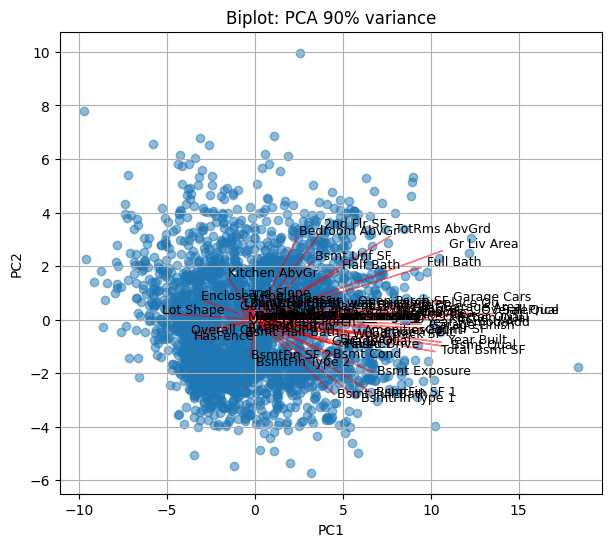

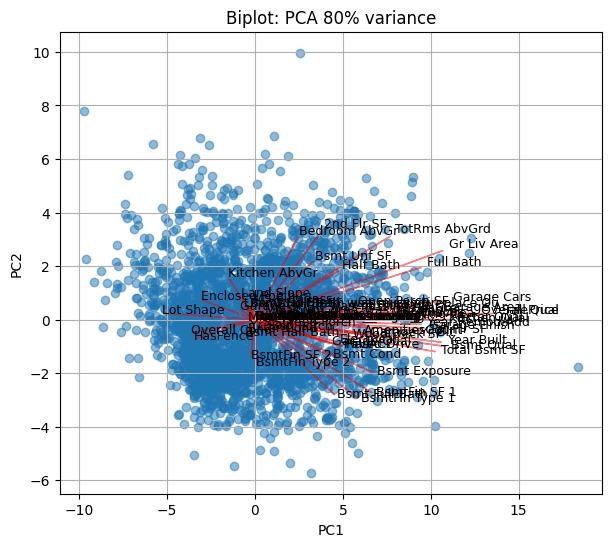

In [41]:
#Versuche den Einfluss der Features auf die wichtigsten zwei principal components zu sehen. Benutze
#loadings = pca.components_.T * np.sqrt(pca.explained_variance_).
#Repräsentiere das grafisch.

# Loop over all PCA thresholds
for t, pca in pca_models.items():
    X_pca = X_pca_dict[t]  # transformed data
    feature_names = X.columns

    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    loadings_2pc = loadings[:, :2]  # first two PCs

    plt.figure(figsize=(7,6))

    plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)

    for i, feature in enumerate(feature_names):
        plt.arrow(0, 0, loadings_2pc[i,0]*15, loadings_2pc[i,1]*5, color='r', alpha=0.5)
        plt.text(loadings_2pc[i,0]*15.5, loadings_2pc[i,1]*5.2, feature, color='black', fontsize=9)
    
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"Biplot: PCA {int(t*100)}% variance")
    plt.grid(True)
    plt.show()

        MS SubClass              Lot Frontage                   Lot Area  \
               mean median count         mean median count          mean   
cluster                                                                    
0         61.229947   60.0   187    71.802139   68.0   187  10218.935829   
1         40.000000   20.0   192    73.609375   73.0   192   9522.593750   
2         60.062893   60.0   159    66.748428   67.0   159   9003.591195   
3         50.141844   50.0   141    60.134752   60.0   141   8636.375887   
4         36.326336   20.0   524    68.064885   68.5   524   9135.612595   
5         20.000000   20.0     2   111.000000  111.0     2  26473.500000   
6         75.474860   85.0   179    62.581006   65.0   179  13877.737430   
7         62.290076   60.0   131    87.618321   85.0   131  13618.007634   
8         40.033333   20.0   300    74.388333   73.0   300  10529.413333   
9         49.615385   60.0    13   123.153846  100.0    13  21798.230769   
10        46

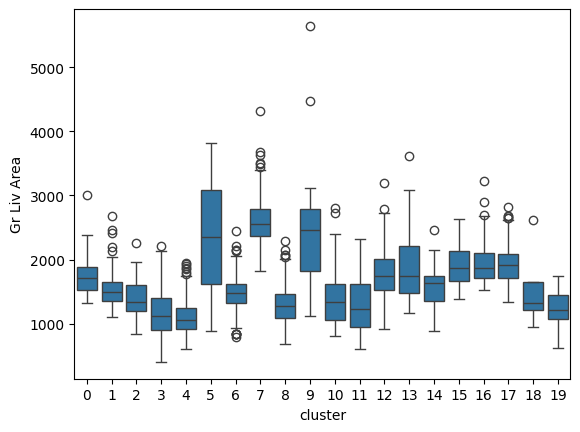

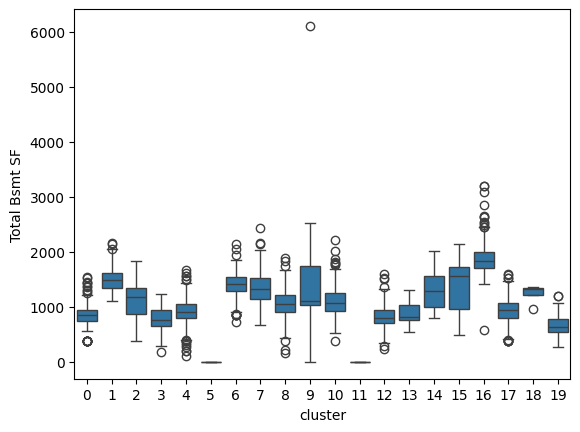

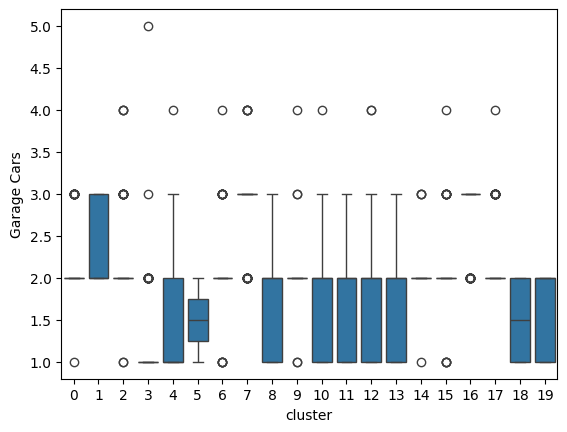

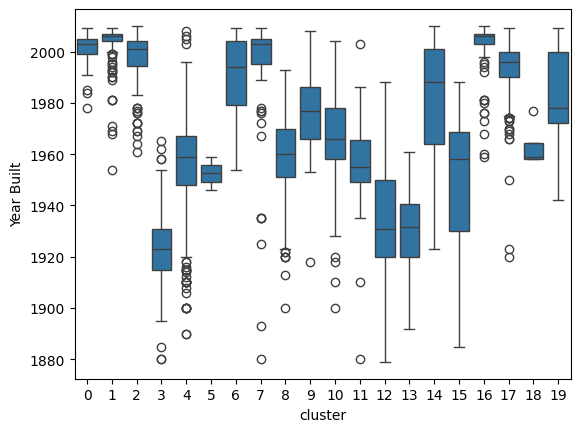

In [ ]:
#Erkläre in eigenen Worten, welche Eigenschaften jedes Cluster hat. Was für Häuser findet man tendenziell in Cluster x?
#Benutze, z.B. Visualisierungen aus L1.
labels = kmeans_models[t].labels_  # cluster assignments for PCA threshold t
df_clustered = df.copy()            # your cleaned original data
df_clustered['cluster'] = labels    # add cluster assignment
numeric_cols = df_clustered.select_dtypes(include=[np.number]).columns
cluster_summary = df_clustered.groupby('cluster')[numeric_cols].agg(['mean', 'median', 'count'])
print(cluster_summary)
#AICI VEDEM STRUCTURA CLUSTERELOR
import seaborn as sns
key_features = ['Gr Liv Area', 'Total Bsmt SF', 'Garage Cars', 'Year Built']
for feature in key_features:
    sns.boxplot(x='cluster', y=feature, data=df_clustered)
    plt.show()

Cluster assignments for new houses: [9 9 9]


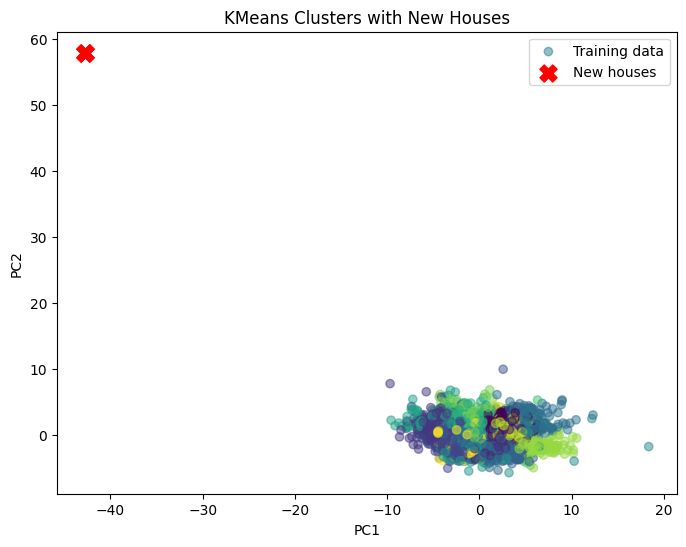

In [56]:
#Gib dem Modell einige ihm unbekannte Datenpunkte. Erfinde selbst ein paar plausible Häuser. Welchem Cluster werden sie zugeordnet? 
#Ist es, intuitiv, richtig oder falsch? Erkläre.
#Hinweis: vor der Inferenz muss man den Datenpunkt mithilfe vom PCA transformieren – warum?
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

new_houses_raw = pd.DataFrame([
    {"LotArea": 5000, "OverallQual": 5, "YearBuilt": 1970, "GarageCars": 1},  # small/old
    {"LotArea": 12000, "OverallQual": 9, "YearBuilt": 2015, "GarageCars": 3}, # large/new
    {"LotArea": 8000, "OverallQual": 6, "YearBuilt": 1995, "GarageCars": 2}   # medium
])

# Add missing columns with 0
for col in training_columns:
    if col not in new_houses_raw.columns:
        new_houses_raw[col] = 0


numeric_columns = df.select_dtypes(include=[np.number]).columns
df_numeric = df[numeric_columns]
training_columns = df_numeric.columns
new_houses_aligned = new_houses_raw[training_columns]
scaler.fit(df_numeric)
new_houses_scaled = scaler.transform(new_houses_aligned)

new_houses_pca = pca.transform(new_houses_scaled)

clusters = kmeans.predict(new_houses_pca)

X_pca = X_pca_dict[0.98] #pentru 0.98
print("Cluster assignments for new houses:", clusters)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans.labels_, cmap='viridis', alpha=0.5, label='Training data')
plt.scatter(new_houses_pca[:,0], new_houses_pca[:,1], c='red', marker='X', s=150, label='New houses')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('KMeans Clusters with New Houses')
plt.legend()
plt.show()
